In [1]:
import os
import tensorflow as tf

num_threads = 40
os.environ["OMP_NUM_THREADS"] = "10"
os.environ["TF_NUM_INTRAOP_THREADS"] = "10"
os.environ["TF_NUM_INTEROP_THREADS"] = "10"

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)

from tensorflow import keras
from tensorflow.keras import models, layers
import uproot
import numpy as np
import pandas as pd


In [38]:

NUMEPOCHS = 1000
PHASEMAX = 50
PERCENTPILEUP = 0.5
NUMTRAINING = 20000
ModelOutputName = 'testingBool'
AUGMENTATION = 10


In [39]:

def GetData(filename, treename="timing"):
    '''
    Returns TFile as a pandas dataframe
    '''
    file = uproot.open(filename)
    tree = file[treename]
    npdf = tree.arrays(library="np")
    df =  pd.DataFrame(npdf, columns=npdf.keys())
    return df

def plot_history(history):
    '''
    Plot training and validation loss and accuracy for task 1-3
    '''
    
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # plot training and validation loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_yscale('log')
    axs[0].legend(['train', 'val'], loc='best')

    # plot training and validation accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title('Model Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['train', 'val'], loc='best')

    plt.savefig('models/'+ModelOutputName+'/history.png')


def GetTraces(values):
    traces = np.zeros((values.shape[0], 300))
    for i in range(values.shape[0]):
        trace = np.array(values[i]).reshape(300, 1)
        traces[i][:] = trace[:, 0]
    return traces


def OneHotEncodePileup(pileup):
    pileup_one_hot = np.zeros((pileup.shape[0], 2))
    for i in range(pileup.shape[0]):
        if pileup[i]<PERCENTPILEUP:
            pileup_one_hot[i][:] = [1, 0]
        else:
            pileup_one_hot[i][:] = [0, 1]
    return pileup_one_hot

def GetPhases(phases):
    phase = np.zeros((phases.shape[0], 1))
    for i in range(phases.shape[0]):
        if phases[i] > 0:
            phase[i] = phases[i]
        else:
            phase[i] = 0.0
    return phase
    
def NormalizeTraces(traces):
    for i in range(len(traces)):
        baseline = np.average(traces[i][0:40])
        traces[i] -= baseline
        tmax = np.amax(traces[i])
        traces[i] /= tmax
    return traces

def BoolNet():
    defSize = 300-4*AUGMENTATION
    input = layers.Input(shape=(defSize,1))
    conv1 = layers.Conv1D(kernel_size=10, filters=64, activation='tanh')(input)
    conv2 = layers.Conv1D(kernel_size=5, filters=64, activation='relu')(conv1)
    max2 = layers.MaxPooling1D(pool_size=1)(conv2)
    conv3 = layers.Conv1D(kernel_size=1, filters=64, activation='relu')(max2)
    max3 = layers.MaxPooling1D(pool_size=1)(conv3)
    conv4 = layers.Conv1D(kernel_size=2, filters=64, activation='relu', padding='same')(max3)
    max4 = layers.MaxPooling1D(pool_size=10)(conv4)
    
    flat1 = layers.Flatten()(max4)
    dense2 = layers.Dense(128, activation='relu')(flat1)
    output = layers.Dense(1, activation='sigmoid')(dense2)
    
    model = models.Model(inputs=input, outputs=output)
    model.summary()
    
    return model

def getRandomPileupTraces(tt1,tt2,rndphase,scale):
  newtot = np.zeros_like(tt1)
  newtt1 = np.zeros_like(tt1)
  newtt2 = np.zeros_like(tt2)
  std2 = np.std(tt2[:60]) # gets deviation for baseline
  for i in range(len(tt1)):
    newtt1[i] = tt1[i]
    if(i<rndphase):
      newtot[i] = tt1[i] + np.random.normal(0,std2)
      newtt2[i] = np.random.normal(0,std2) # gaussian random for baseline
    else:
      i2 = int(i-rndphase)
      newtt2[i] = (tt2[i2+1]-tt2[i2])*(rndphase-int(rndphase))+tt2[i2]
      newtt2[i] *= scale
      newtot[i] = tt1[i] + newtt2[i] + np.random.normal(0,std2)
  max = np.max(newtot)
  nmin = np.min(newtot)
  min = newtt2[-1] if newtt1[-1]>newtt2[-1] else  newtt1[-1] #normalizes bottom
  scale = max-nmin
  # print(max,nmin,min,scale)
  return (newtot)/max,newtt1/max,newtt2/max

def augmentTraces(dataset,numAugs,labels=None,otherdata=None):
  newData = []
  newLabels = []
  newOther = []
  for iter in range(len(dataset)):
    for i in range(numAugs):
      newData.append(dataset[iter][4*i:-4*numAugs+4*i])
      newLabels.append(labels[iter])
      newOther.append(otherdata[iter])
  newData = np.array(newData)
  newLabels = np.array(newLabels)
  newOther = np.array(newOther)
  return newData, newLabels, newOther

def augmentDepiled(dataset,numAugs):
  newData = []
  for iter in range(len(dataset)):
    for i in range(numAugs):
      t1 = dataset[iter][0][4*i:-4*numAugs+4*i]
      t2 = dataset[iter][1][4*i:-4*numAugs+4*i]
      hold = []
      hold.append(t1)
      hold.append(t2)
      newData.append(hold)
  newData = np.array(newData)
  return newData



In [40]:

pdf = GetData("ysoTracesNoPileup.root")
pdf = pdf[pdf["trace"].apply(lambda x: x.shape[0] == 300)].reset_index(drop=True)
#pile_up_one_hot = OneHotEncodePileup(pdf["pileup"].values)
phase_shifts = GetPhases(pdf["phase"].values)
traces = GetTraces(pdf["trace"].values)
print('Loaded Data')


traces_no_pileup = pdf["trace"].values[pdf["pileup"].values == False]
rand_phase_shifts = np.random.uniform(0.1, PHASEMAX, traces_no_pileup.shape[0])
rand_amplitude_shifts = np.random.uniform(0.5, 1.5, traces_no_pileup.shape[0])
rand_ifPile = np.random.uniform(0, 1, traces_no_pileup.shape[0])

phase_amplitude = np.zeros((traces_no_pileup.shape[0], 2))
traces_depiled = np.zeros((traces_no_pileup.shape[0], 2, 300))
traces_piledup = np.zeros((traces_no_pileup.shape[0], 300,1))

pileBool = []
for i in range(traces_no_pileup.shape[0]):
    if rand_ifPile[i]<PERCENTPILEUP:
        rand_trace = int(np.random.uniform(0,traces_no_pileup.shape[0]))
        traces_piledup[i][:,0],traces_depiled[i][0][:],traces_depiled[i][1][:] = getRandomPileupTraces(traces_no_pileup[i][:300],traces_no_pileup[rand_trace][:300],rand_phase_shifts[i],rand_amplitude_shifts[i])
        phase_amplitude[i][0] = rand_phase_shifts[i]
        phase_amplitude[i][1] = rand_amplitude_shifts[i]
        pileBool.append(1)
    else:
        traces_piledup[i][:,0] = traces_no_pileup[i][:300]
        traces_depiled[i][0][:] = traces_no_pileup[i][:300]
        traces_depiled[i][1][:] = np.zeros_like(traces_no_pileup[i][:300])
        phase_amplitude[i][0] = 0.
        phase_amplitude[i][1] = 0.
        pileBool.append(0)

# pileBool = [[1] if r>PERCENTPILEUP else [0] for r in rand_ifPile]
# pileBool = np.array(pileBool)

print('Formatted Data')
traces_piledup,phase_amplitude, pileBool = augmentTraces(traces_piledup,AUGMENTATION,phase_amplitude, pileBool)
print('Augmented Traces')
traces_depiled = augmentDepiled(traces_depiled,AUGMENTATION)
print('Augmented Depiled')


Loaded Data
Formatted Data
Augmented Traces
Augmented Depiled


In [41]:

model = BoolNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 260, 1)]          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 251, 64)           704       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 247, 64)           20544     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 247, 64)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 247, 64)           4160      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 247, 64)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 247, 64)           8256

In [42]:

train_x = traces_piledup[:NUMTRAINING]
train_y = pileBool[:NUMTRAINING]
history = model.fit(train_x, train_y, epochs=NUMEPOCHS, batch_size=256, validation_split=0.2, verbose=2)


Epoch 1/1000
63/63 - 4s - loss: 0.3204 - accuracy: 0.8476 - val_loss: 0.1703 - val_accuracy: 0.9532
Epoch 2/1000
63/63 - 3s - loss: 0.1096 - accuracy: 0.9599 - val_loss: 0.0607 - val_accuracy: 0.9745
Epoch 3/1000
63/63 - 3s - loss: 0.0851 - accuracy: 0.9668 - val_loss: 0.1034 - val_accuracy: 0.9620
Epoch 4/1000
63/63 - 3s - loss: 0.0556 - accuracy: 0.9786 - val_loss: 0.0567 - val_accuracy: 0.9800
Epoch 5/1000
63/63 - 3s - loss: 0.1275 - accuracy: 0.9554 - val_loss: 0.0419 - val_accuracy: 0.9825
Epoch 6/1000
63/63 - 4s - loss: 0.0605 - accuracy: 0.9778 - val_loss: 0.0423 - val_accuracy: 0.9885
Epoch 7/1000
63/63 - 4s - loss: 0.0378 - accuracy: 0.9861 - val_loss: 0.0324 - val_accuracy: 0.9898
Epoch 8/1000
63/63 - 4s - loss: 0.0316 - accuracy: 0.9887 - val_loss: 0.0239 - val_accuracy: 0.9930
Epoch 9/1000
63/63 - 4s - loss: 0.0306 - accuracy: 0.9891 - val_loss: 0.0371 - val_accuracy: 0.9815
Epoch 10/1000
63/63 - 4s - loss: 0.0291 - accuracy: 0.9891 - val_loss: 0.0424 - val_accuracy: 0.9840

INFO:tensorflow:Assets written to: models/testingBool/assets


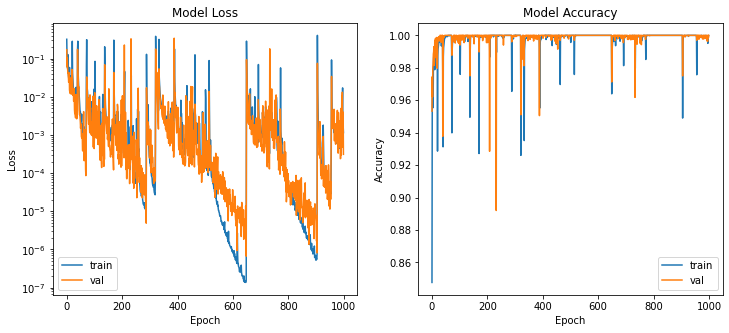

In [43]:

#### Saving the model
model.save('models/'+ModelOutputName)
plot_history(history)


In [44]:

test_x = traces_piledup[NUMTRAINING:NUMTRAINING+10000]
test_y = pileBool[NUMTRAINING:NUMTRAINING+10000]
test_p = phase_amplitude[NUMTRAINING:NUMTRAINING+10000,0]
test_a = phase_amplitude[NUMTRAINING:NUMTRAINING+10000,1]
test_y_hat = model.predict(test_x)
# y = [1 if y[1]>y[0] else 0 for y in test_y]
# y = np.array(y)
# y_hat = [1 if y[1]>y[0] else 0 for y in test_y_hat]
# y_hat = np.array(y_hat)


In [45]:
print(test_y_hat.shape)

(10000, 1)


Text(0, 0.5, 'Predicted Pileup')

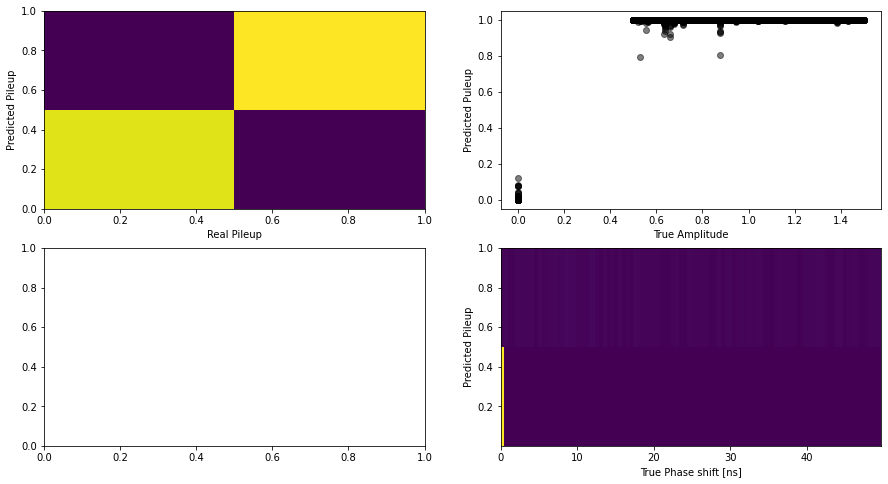

In [48]:

import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(2, 2 ,figsize=(15, 8))
n = np.random.randint(0, test_x.shape[0])

ax[0][0].hist2d(test_y,test_y_hat[:,0],bins=2,range=((0,1),(0,1)))
ax[0][0].set_xlabel("Real Pileup")
ax[0][0].set_ylabel("Predicted Pileup")

ax[0][1].plot(test_a,test_y_hat[:,0], 'o', color='black',alpha=0.5)
ax[0][1].set_xlabel("True Amplitude")
ax[0][1].set_ylabel("Predicted Puleup")

ax[1][1].hist2d(test_p,test_y_hat[:,0],bins=(100,2))
ax[1][1].set_xlabel("True Phase shift [ns]")
ax[1][1].set_ylabel("Predicted Pileup")

# plt.savefig('models/'+ModelOutputName+'/residuals.png')

